In [1]:
import sys

sys.path.insert(1, '../../Databank/Scripts/BuildDatabank/')
from databankLibrary import download_link, lipids_dict, databank

path = '../Data/MD-PERMEATION/'
db_data = databank(path)
systems = db_data.get_systems()

/home/osollila/.conda/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")


In [31]:
import matplotlib.pyplot as plt
import json
import numpy as np
import pandas as pd
import seaborn as sn
import os
import scipy.stats

def CalcAreaPerMolecule(system):
    path = system['path']
    APLpath = path.replace('../Data/MD-PERMEATION/', '../../Databank/Data/Simulations/')
    APLpath = APLpath + 'apl.json'
    #try:
    f = open(APLpath)
    APLdata = json.load(f)
    sumAPL = 0
    sumIND = 0
    for i,j in APLdata.items():
        sumAPL += j
        sumIND += 1
    APL = sumAPL/sumIND
    return(APL)
    #except:
    #    print('apl.json not found from' + APLpath)
        
def calcArea(system):
    APL = CalcAreaPerMolecule(system)
    Nlipid = 0
    for molecule in system['COMPOSITION']:
        if molecule in lipids_dict:
            Nlipid += np.sum(system['COMPOSITION'][molecule]['COUNT'])
    return Nlipid/(2*APL)

def GetThickness(system):
    path = system['path']
    ThicknessPath = path.replace('../Data/MD-PERMEATION/', '../../Databank/Data/Simulations/')
    ThicknessPath = ThicknessPath + 'thickness.json'
    #try:
    f = open(ThicknessPath)
    thickness = json.load(f)
    return(thickness)
    #except:
    #    pass
    #    print('thickness.json not found from' + system['path'])
    

def calcLipidFraction(system, lipid):
    NlipidTOT = 0
    for molecule in system['COMPOSITION']:
        if molecule in lipids_dict:
            NlipidTOT += np.sum(system['COMPOSITION'][molecule]['COUNT'])
    
    Nlipid = 0
    for molecule in system['COMPOSITION']:
        if lipid in molecule:
            Nlipid += np.sum(system['COMPOSITION'][molecule]['COUNT'])
            
    return Nlipid/NlipidTOT

def chargedFraction(system):
    Nlipid = 0
    for molecule in system['COMPOSITION']:
        if molecule in lipids_dict:
            Nlipid += np.sum(system['COMPOSITION'][molecule]['COUNT'])
    
    Ncharged = 0
    chargedlipids = ['POPG', 'POPS', 'DPPG', 'DOPS', 'POPI', 'SAPI', 'SLPI', 'DHMDMAB']
    for molecule in system['COMPOSITION']:
        if molecule in chargedlipids:
            Ncharged += np.sum(system['COMPOSITION'][molecule]['COUNT'])
            
    return Ncharged/Nlipid


def getHydrationLevel(system):
    Nlipid = 0
    for molecule in system['COMPOSITION']:
        if molecule in lipids_dict:
            Nlipid += np.sum(system['COMPOSITION'][molecule]['COUNT'])
    Nwater = system['COMPOSITION']['SOL']['COUNT']
    return Nwater/Nlipid

def getWaterPermeationRate(system):
    path = system['path']
    with open(path + 'Counting_events.txt', 'r') as f:
        last_line = f.readlines()[-1]
    last_line = last_line.split()
    time = float(last_line[0])
    count = float(last_line[1])
    area = calcArea(system)
    rate = count / (time * area)
    return rate

def getWaterLateralDiffusion(system):
    path = system['path']
    waterDIFFUSIONpath = path.replace('../Data/MD-PERMEATION/', '../Data/WATERdiffusion/')
    waterDIFFUSIONpath = waterDIFFUSIONpath + 'WATERlateralMSD.xvg'
    D = float(os.popen('grep D ' + waterDIFFUSIONpath + " | grep = | awk '{print $5}'").read())
    return D
    
def plotCorrelation(xProperty,yProperty,permeationResults):
    xPropertyData = []
    yPropertyData = []
    for ID in permeationResults:
        xPropertyData.append(permeationResults[ID][xProperty])
        yPropertyData.append(permeationResults[ID][yProperty])
    plt.plot(xPropertyData,yPropertyData,'.')
    
def averageOrderParameters(system):
    
    #DataBankPath = '../../Databank/Data/'
    #path = DataBankPath + system['path']
    
    pathTMP = system['path']
    path = pathTMP.replace('../Data/MD-PERMEATION/', '../../Databank/Data/Simulations/')
    
    sn1sum = 0
    sn1count = 0
    sn2sum = 0
    sn2count = 0
    
    for lipid in system['COMPOSITION']:
        if lipid in lipids_dict and not 'CHOL' in lipid:
            OPpathSIM = path + lipid + 'OrderParameters.json'
            with open(OPpathSIM) as json_file:
                OPsim = json.load(json_file)
    
            for key in OPsim:
                if 'M_G1C' in key:
                    sn1sum += float(OPsim[key][0][0])
                    sn1count += 1
                elif 'M_G2C' in key:
                    sn2sum += float(OPsim[key][0][0])
                    sn2count += 1
                    
    return sn1sum/sn1count, sn2sum/sn2count



In [42]:
permeationVStemperature = {}
ID = 0
for system in systems:
    path = system['path']
    
    try:
        rate = getWaterPermeationRate(system)
    except:
        print('Water permeation failed, setting rate to 0: ' + path)
        rate = 0
        #continue
    
    WaterLateralDiffusion = getWaterLateralDiffusion(system)
    
    #if rate > 0:
    PermeationDiffusionRatio = rate/WaterLateralDiffusion
    #else:
    #    PermeationDiffusionRatio = 'nan'
    
    APL = CalcAreaPerMolecule(system)
    
    try:
        thickness = GetThickness(system)
    except:
        thickness = float('nan')

    area = calcArea(system)   
    
    tailOPavg = np.average(averageOrderParameters(system))
    #print(tailOPavg)
    if str(tailOPavg) == 'nan':
        print(system)
    
    
    hydration = getHydrationLevel(system)
    
    CholFraction = calcLipidFraction(system, 'CHOL')
    
    POPGFraction = calcLipidFraction(system, 'POPG')
    
    POPSFraction = calcLipidFraction(system, 'POPS')
    
    POPEFraction = calcLipidFraction(system, 'POPE')
    
    ChargedFraction = chargedFraction(system)
    
    temperature = system['TEMPERATURE']
    
    ID += 1
    permeationVStemperature[ID] = {
        'path': path, 
        'temperature': temperature ,
        'permeation': rate, 
        'APL': APL, 
        'CholFraction': CholFraction,
        'POPGFraction': POPGFraction,
        'POPSFraction': POPSFraction,
        'POPEFraction': POPEFraction,
        'hydration': hydration,
        'thickness': thickness,
        'ChargedFraction': ChargedFraction,
        'WaterLateralDiffusion' : WaterLateralDiffusion,
        'PermeationDiffusionRatio' : PermeationDiffusionRatio,
        'area' : area,
        'TailOrder' : tailOPavg
    }
        
        
    #!ls {path}
    #for key in system:
    #    print(key, ':',system[key])
    #print('')

Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/019/eb8/019eb8d7691998587faa1e618272a564ff9e697e/577a6cc9d00effd20baf941d520a23d91701352d/
Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/02b/984/02b98418d9965749ac943ecae9627cfdd1dfbdcd/7339faa76da6c93cfee03e59f399e2eed1628b53/
Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/0a4/101/0a41017641414540973e921ed22528d1f3dc414b/3c0936e61fa40cce74fd1828a2697742709e91fb/
Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/0bc/296/0bc296850dd41d32a6e9aa4ac2b5dd4e84a6605f/e64b1a6ceccc9a361529be902c17c2b4b0394484/
Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/0e9/f5e/0e9f5e64ad7244273eb2f544966ba7dd606fbbb1/2578273ee378997849b0bec8b8b3414797cdce73/
Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/0f2/d02/0f2d02d844c1290ae8e9b058d19e92065e71dd06/a5d989590567888284ba4d86b1cfe674af0f8c19/
Water permeation failed, setting rate to 0: ../Data/MD-PER

Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/f83/806/f83806c3a0af6edc5b32cd7769ac7e689b4c5331/f0ccd45496dd8a2bb993c75e728bac817cf3bae8/
Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/fd8/18f/fd818f1fa1b32dcd80ac3a124e76bd2d73705abe/fd9cef87eca7bfbaac8581358f2d8f13d8d43cd1/
Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/49d/6ce/49d6cefb7e4c1b186ac65c40414c69ef572a62b8/91b0cb04ece782a635633afefdb3950963e9c4a5/
Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/4e4/d45/4e4d45f15fc334edfa725ef670c7ec1f86589d3e/247e995fe4c17b8643ee8c9fb6760a383f65f024/
Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/503/bbb/503bbb64862a9cf4f574189806dfdd25f88e6a14/41807262ab583f3f5dd05af4b7786bc6889239fc/
Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/508/748/5087483af99bfbd427630e5974e20aea6d34b2ae/4062f0e472c77353fc638996ae7dfcb505f3433e/
Water permeation failed, setting rate to 0: ../Data/MD-PER

(0.0, 0.2)

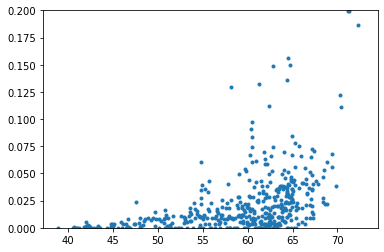

In [20]:
plotCorrelation('APL','permeation',permeationVStemperature)
plt.ylim([0,0.2])

(3.0, 6.0)

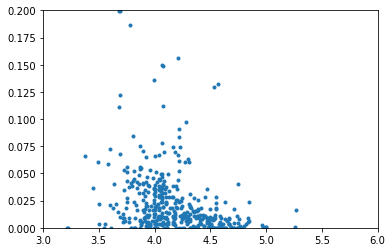

In [5]:
plotCorrelation('thickness','permeation',permeationVStemperature)
plt.ylim([0,0.2])
plt.xlim([3,6])

(0.0, 0.2)

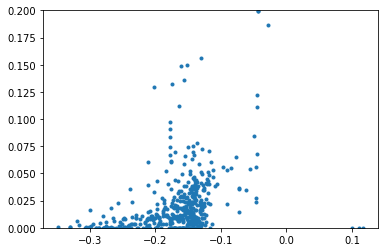

In [22]:
plotCorrelation('TailOrder','permeation',permeationVStemperature)
plt.ylim([0,0.2])

(0.0, 0.2)

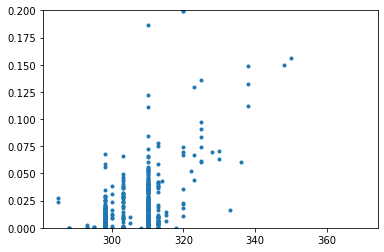

In [6]:
plotCorrelation('temperature','permeation',permeationVStemperature)
plt.ylim([0,0.2])

(0.0, 0.2)

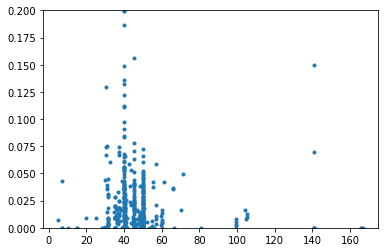

In [7]:
plotCorrelation('hydration','permeation',permeationVStemperature)
plt.ylim([0,0.2])

(0.0, 11.0)

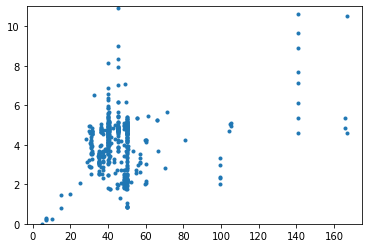

In [8]:
plotCorrelation('hydration','WaterLateralDiffusion',permeationVStemperature)
plt.ylim([0,11])

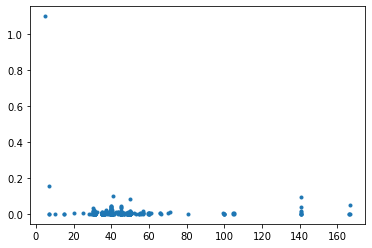

In [9]:
plotCorrelation('hydration','PermeationDiffusionRatio',permeationVStemperature)
#plt.ylim([0,0.05])

(0.0, 0.2)

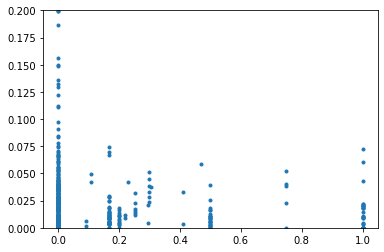

In [10]:
plotCorrelation('ChargedFraction','permeation',permeationVStemperature)
plt.ylim([0,0.2])

(0.0, 0.2)

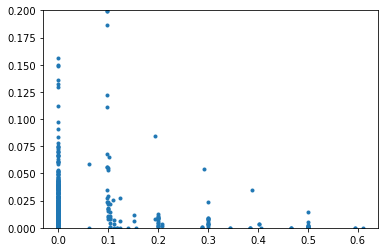

In [11]:
plotCorrelation('CholFraction','permeation',permeationVStemperature)
plt.ylim([0,0.2])

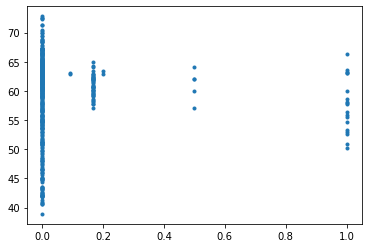

In [12]:
plotCorrelation('POPSFraction','APL',permeationVStemperature)

In [45]:
data = {}
for prop in permeationVStemperature[1]:
    if prop == 'path':
        continue
    data[prop] = []

for ID in permeationVStemperature:
    for prop in permeationVStemperature[ID]:
        if prop == 'path':
            continue
        data[prop].append(permeationVStemperature[ID][prop])
        #print(ID,prop)

columns = []
for i in data:
    columns.append(i)

df = pd.DataFrame(data,columns=columns)
#print (df)

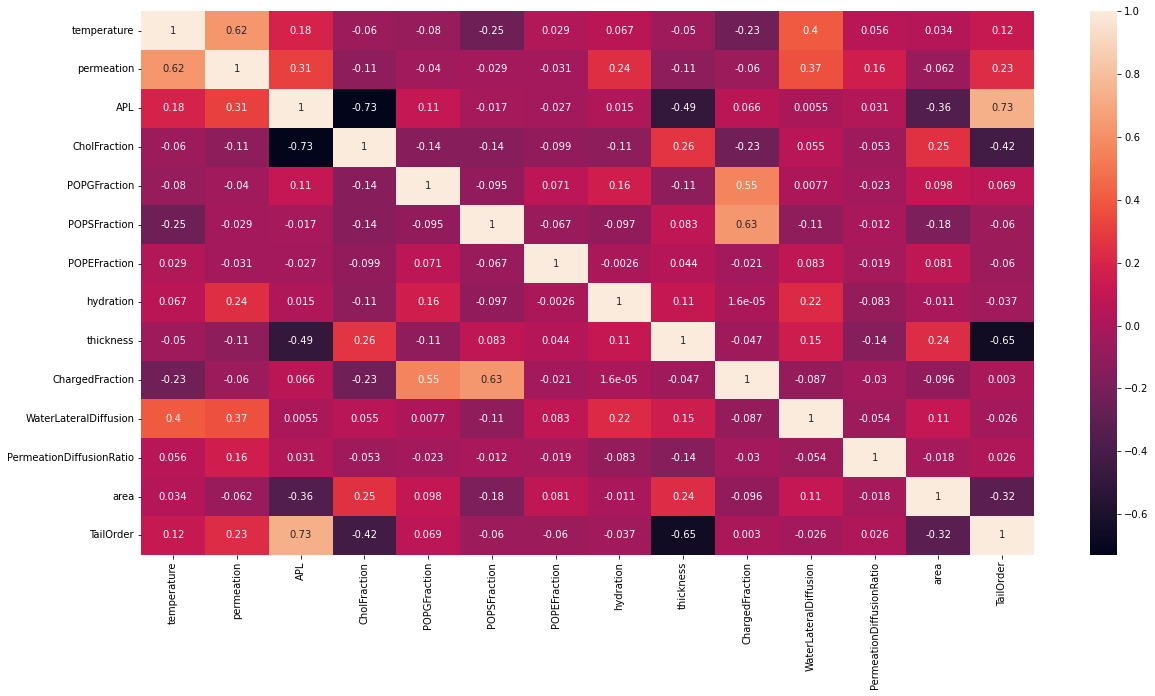

In [25]:
corrMatrix = df.corr()
#print (corrMatrix)
plt.figure(figsize = (20,10))
sn.heatmap(corrMatrix, annot=True)

plt.show()


In [70]:
scipy.stats.pearsonr(data['ChargedFraction'],data['APL'])

(0.06608743924888374, 0.15170152112878688)

In [71]:
scipy.stats.spearmanr(data['ChargedFraction'],data['APL'])

SpearmanrResult(correlation=-0.008487646519376264, pvalue=0.8540815067557631)

In [52]:
df

,temperature,permeation,APL,CholFraction,POPGFraction,POPSFraction,POPEFraction,hydration,thickness,ChargedFraction,WaterLateralDiffusion,PermeationDiffusionRatio,area,TailOrder
0,310.15,0.018045,58.912310,0.099099,0.0,0.000000,0.0,40.540541,4.200446,0.000000,4.7147,0.003827,1.884156,-0.162092
1,310.00,0.019490,64.967140,0.000000,0.0,0.000000,0.0,45.000000,4.004265,0.000000,4.7157,0.004133,1.539240,-0.128373
2,313.00,0.078335,65.279236,0.000000,0.0,0.000000,0.0,45.000000,4.064088,0.000000,4.9253,0.015905,1.531881,-0.136642
3,310.00,0.000000,40.991445,0.593750,0.0,0.000000,0.0,50.000000,4.018039,0.000000,5.3119,0.000000,1.561301,-0.245352
4,315.00,0.014511,53.579101,0.104167,0.0,0.000000,0.0,40.312500,4.352813,0.000000,5.1716,0.002806,10.750460,-0.211341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467,298.00,0.005015,59.891034,0.000000,0.0,0.166667,0.0,49.458333,4.169058,0.166667,2.1653,0.002316,0.601092,-0.146895
468,303.00,0.000000,61.151473,0.000000,0.0,0.000000,0.0,28.958333,2.560888,0.000000,3.1398,0.000000,0.588702,-0.159199
469,298.00,0.000000,53.233046,0.000000,0.0,1.000000,0.0,35.000000,4.641512,1.000000,3.6934,0.000000,1.202261,-0.213670
470,300.00,0.009092,58.190420,0.000000,0.0,0.000000,0.5,35.554688,4.250576,0.000000,3.9584,0.002297,2.199675,-0.177945
